In [196]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

## Feature Selection Demonstration: Permutation Importance

In our dataset with over 2000 features, we use a visualization step before applying permutation importance. This involves:

1. **Selecting a Random Subset**: We start by sampling 50 features to manage complexity for demonstration purposes. In the actual code we start with all features.
2. **Hierarchical Clustering Dendrogram**: Visualizes feature similarity, helping to identify clusters of related features.
3. **Correlation Matrix Heatmap**: Highlights the linear relationships between features, identifying redundancy.

These visualizations are useful for understanding how the iterative refining process works.

Note: This implementation is based on the sklearn documentation. However, ours is modified to iteratively reduce features at or below the 0 score

In [11]:
import ast # used for parsing string to list
import os
import textwrap
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.base import clone
from utils.constants import SEED, TARGET, SPLIT_TYPE
from select_models import baseline_models, model_needs_scaling, timing_decorator


In [126]:
def set_drop_columns(target):
    drop = None
    if target == 'bear':
        drop = ['USREC', 'S&P500 Price - Inflation Adjusted',
            'S&P500 Dividend Yield',
            'S&P500 PE ratio',
            'S&P500 Earnings Yield',
            'S&P500 Price - Inflation Adjusted_3M_lag',
            'S&P500 Price - Inflation Adjusted_6M_lag',
            'S&P500 Price - Inflation Adjusted_9M_lag',
            'S&P500 Price - Inflation Adjusted_12M_lag',
            'S&P500 Price - Inflation Adjusted_18M_lag',
            'S&P500 Dividend Yield_3M_lag',
            'S&P500 Dividend Yield_6M_lag',
            'S&P500 Dividend Yield_9M_lag',
            'S&P500 Dividend Yield_12M_lag',
            'S&P500 Dividend Yield_18M_lag',
            'S&P500 PE ratio_3M_lag',
            'S&P500 PE ratio_6M_lag',
            'S&P500 PE ratio_9M_lag',
            'S&P500 PE ratio_12M_lag',
            'S&P500 PE ratio_18M_lag',
            'S&P500 Earnings Yield_3M_lag',
            'S&P500 Earnings Yield_6M_lag',
            'S&P500 Earnings Yield_9M_lag',
            'S&P500 Earnings Yield_12M_lag',
            'S&P500 Earnings Yield_18M_lag']
        print("Dropped S&P and USREC columns")
        return drop
    
    if target == 'Regime':
        drop = ['USREC', 'USREC_3M_lag', 'USREC_6M_lag', 'USREC_9M_lag', 'USREC_12M_lag', 'USREC_18M_lag']
        print("Dropped USREC column")
        return drop
    
    print("No columns dropped")
    return drop

def load_data(target='bear', split='std', subset=None, seed=SEED):
    base_path = "split_data/"
    X_train_file = f"X_train_{target}_{split}.csv"
    y_train_file = f"y_train_{target}_{split}.csv"
    X_test_file = f"X_test_{target}_{split}.csv"
    y_test_file = f"y_test_{target}_{split}.csv"
    
    X_train = pd.read_csv(base_path + X_train_file)
    y_train = pd.read_csv(base_path + y_train_file)
    X_test = pd.read_csv(base_path + X_test_file)
    y_test = pd.read_csv(base_path + y_test_file)
    print(f"Loaded {X_train_file}, {y_train_file}, {X_test_file}, and {y_test_file}.")
    
    drop_columns = set_drop_columns(target)

    if drop_columns:
    # Drop the USREC column from X_train and X_test
        X_train = X_train.drop(columns=drop_columns) # Maybe do this in the split_data script?
        X_test = X_test.drop(columns=drop_columns)

    if subset:
        # Sample columns
        print(f"Subsetting data to {subset} random columns.")
        sampled_columns = X_train.sample(n=subset, axis=1, random_state=seed).columns
        
        X_train = X_train[sampled_columns]
        X_test = X_test[sampled_columns]

    #return dropped columns for descriptive visualization title
    return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()

In [127]:
X_train, y_train, X_test, y_test = load_data(target='Regime', split=SPLIT_TYPE, seed=SEED)
# find all columns that contain USREC
usrec_columns = [col for col in X_train.columns if 'USREC' in col]
usrec_columns

Loaded X_train_Regime_std.csv, y_train_Regime_std.csv, X_test_Regime_std.csv, and y_test_Regime_std.csv.
Dropped USREC column


[]

In [128]:
def train_classifier(model, X_train, y_train):
    clf = model
    clf.fit(X_train, y_train)
    return clf

def create_correlation_matrix(X):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    return corr

def perform_hierarchical_clustering(corr, method='ward'):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.linkage(squareform(distance_matrix), method=method)
    return dist_linkage

def plot_dendrogram(X, ax):
    corr = create_correlation_matrix(X)
    dist_linkage = perform_hierarchical_clustering(corr)
    dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax, leaf_rotation=90)
    return dendro

def plot_heatmap(corr, dendro, ax):
    ax.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax.set_xticks(np.arange(0, len(dendro["ivl"])))
    ax.set_yticks(np.arange(0, len(dendro["ivl"])))
    ax.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro["ivl"])

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [129]:
n = 50 # Number of columns to sample

X_train, y_train, X_test, y_test = load_data(subset=n)
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)

clf = train_classifier(RandomForestClassifier(random_state=SEED), X_train, y_train)
print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")


Loaded X_train_bear_std.csv, y_train_bear_std.csv, X_test_bear_std.csv, and y_test_bear_std.csv.
Dropped S&P and USREC columns
Subsetting data to 50 random columns.
Baseline accuracy on test data: 0.92


Davies–Bouldin Index: 1.700367454871306


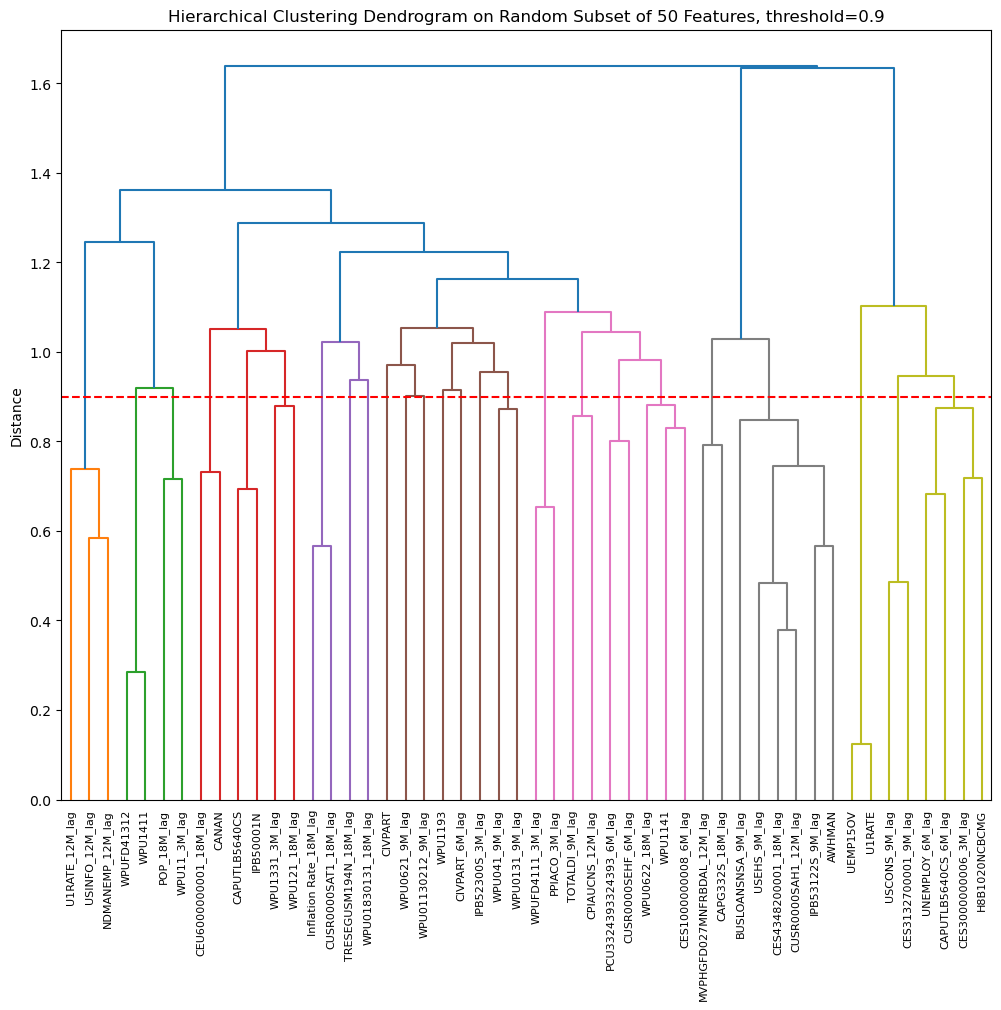

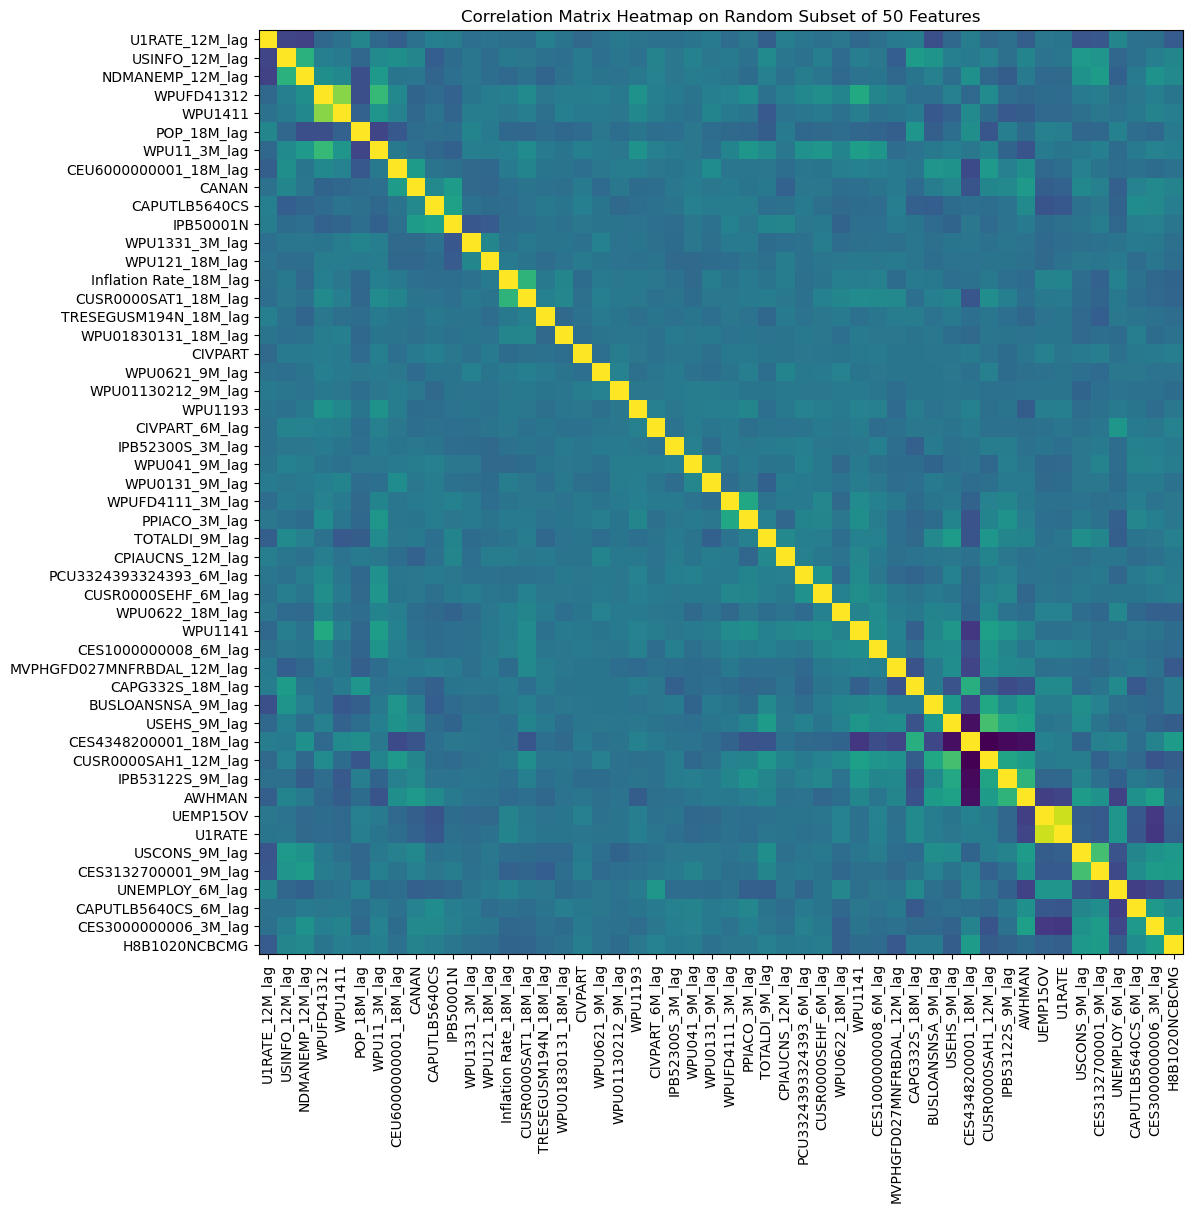

In [130]:
# Plot Dendrogram
from sklearn.metrics import davies_bouldin_score


threshold = 0.9
fig1, ax1 = plt.subplots(figsize=(12, 10))
dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X))
dendro = plot_dendrogram(X, ax1)
# Assuming `dendro` is the result from `plot_dendrogram` that contains linkage matrix
# Convert dendrogram/ linkage matrix into flat clusters based on the threshold
clusters = hierarchy.fcluster(dist_linkage, t=threshold, criterion='distance')

# Transpose X to treat features as samples for DBI calculation
X_transposed = X.T

# Calculate Davies–Bouldin Index
db_index = davies_bouldin_score(X_transposed, clusters)

print(f"Davies–Bouldin Index: {db_index}")


plt.title(f'Hierarchical Clustering Dendrogram on Random Subset of {n} Features, threshold={threshold}')
# plt.title(f'Hierarchical Clustering Dendrogram on All Features, threshold={threshold}')
ax1.set_ylabel('Distance')
# horizontal line at y=threshold
ax1.axhline(y=threshold, color='r', linestyle='--')
plt.show()

# Plot Heatmap
fig2, ax2 = plt.subplots(figsize=(22, 12))
corr = create_correlation_matrix(X)
plot_heatmap(corr, dendro, ax2)
plt.title(f'Correlation Matrix Heatmap on Random Subset of {n} Features')
plt.show()
# ward
# threshold=1.09 # Davies–Bouldin Index: 3.4522
# threshold=2 # Davies–Bouldin Index: 3.9264
# threshold=1.5 # Davies–Bouldin Index: 3.4059
# 1.49, #Davies–Bouldin Index: 3.4014829917233382
# 1.487 Davies–Bouldin Index: 3.401447313077474
# average
# .1 Davies–Bouldin Index: 1.3199189399000935
# .2 Davies–Bouldin Index: 1.6758297764854881
# .15 Davies–Bouldin Index: 1.3476055503540585
# .12 Davies–Bouldin Index: 1.3195973286242964
# .08 Davies–Bouldin Index: 1.053793870939737
# .05 Davies–Bouldin Index: 1.052769600923777
# .025 Davies–Bouldin Index: 0.7708733762639212



## Iterative Feature Refinement Process

This code snippet demonstrates our iterative process for refining feature selection through hierarchical clustering and permutation importance. 

1. **Hierarchical Clustering**: We cluster features based on their correlation, reducing redundancy by selecting only one feature per cluster.
2. **Permutation Importance**: We assess the remaining features' impact on model accuracy, visualizing this through permutation importance plots.

Features at or below a 0 score line are iteratively removed, as they do not contribute to, or may even reduce model accuracy. This reduction ensures our model relies only on features that enhance predictive performance. 

(Note: Although the demo on the sklearn documentation shows an increase in scores after feature reduction, the scores in this demonstration are *decreased* because we are random sampling a much smaller subset so that the prior dendrogram and correlation matrix visualizations are not too overcrowded.)

In [131]:
dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X)) # Recreate the distance matrix

def select_features_by_cluster(X, dist_linkage, threshold=1):
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return X.columns[selected_features]

selected_features_names = select_features_by_cluster(X, dist_linkage, threshold=threshold)

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]
clf_sel = train_classifier(RandomForestClassifier(random_state=SEED), X_train_sel, y_train)

print(
    "Baseline accuracy on test data with features removed:" # See note in the markdown comments above
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.89


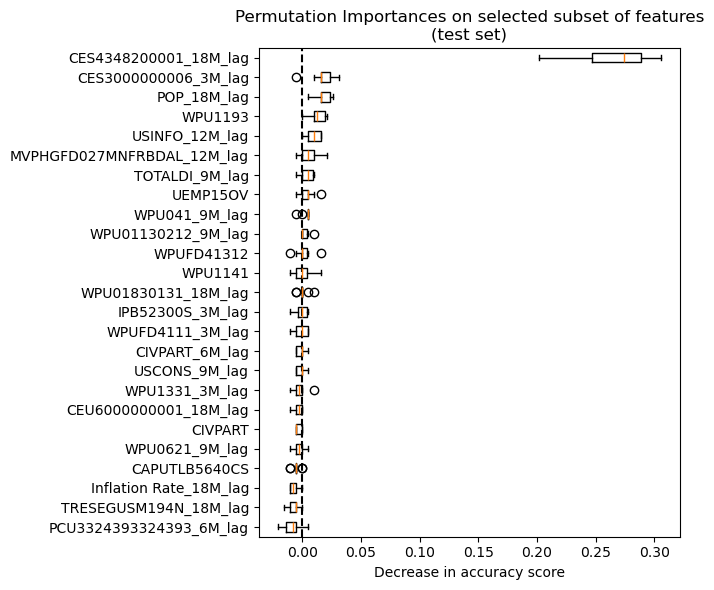

In [132]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

## First Iteration
Iteratively remove features scoring at or below 0. Feature significance varies by dataset, target, and classifier type. A feature's score may change with iterations as feature combinations impact model performance differently. If the score goes down on the next iteration, then the previous set of best features is kept

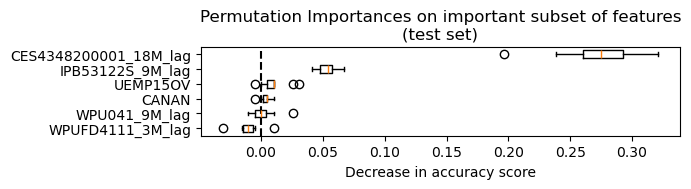

Baseline accuracy on test data with features removed: 0.89


In [133]:
def filter_features_by_importance(X, perm_importance, threshold=0.005):
    """Returns the subset of features that have an importance mean above the threshold."""
    important_feature_indices = np.where(perm_importance.importances_mean >= threshold)[0]
    important_features = X.columns[important_feature_indices]
    return important_features

result = permutation_importance(clf_sel, X_test_sel, y_test, n_repeats=10, random_state=42, n_jobs=-1)

X_train_important = X_train[filter_features_by_importance(X_train, result, threshold=0.005)]
X_test_important = X_test[filter_features_by_importance(X_train, result, threshold=0.005)]
clf_important = train_classifier(RandomForestClassifier(random_state=SEED), X_train_important, y_train)

# plot
fig, ax = plt.subplots(figsize=(7, 2))
plot_permutation_importance(clf_important, X_test_important, y_test, ax)
ax.set_title("Permutation Importances on important subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_important.score(X_test_important, y_test):.2}"
)

In [167]:
def export_results(best_scores, best_features, filename='feature_selection_results.csv'):
    base_path = "feature_selection/"
    results_df = pd.DataFrame(best_scores.items(), columns=['model', 'best_score'])
    results_df['best_features'] = best_features.values()

    results_df = results_df.dropna()

    # tab separated file
    results_df.to_csv(base_path + filename, index=False, sep='\t')
    print(f"Results exported to {filename}")

    # Parse the 'best_features' column from string representation of a list to an actual list
    # results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def calculate_permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    result = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    return result

def get_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions, average='macro', zero_division=0),
        'recall': recall_score(y_test, predictions, average='macro'),
        'f1_score': f1_score(y_test, predictions, average='macro'),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    return metrics

def scale_data(X_train, X_test=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    
    # Convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) if X_test is not None else None
    
    return X_train_scaled_df, X_test_scaled_df

@timing_decorator
def optimize_and_evaluate(models, target_types, split_types, threshold=0.25, n_iterations=5, sample=None, seed=SEED, visualize=False):
    """
    Optimizes models using permutation importance feature selection and evaluates them.
    Optionally visualizes the permutation importance results.
    Returns the best scores and features for each model.
    """
    print(f"\nFinding best features for {len(models)} models on {len(target_types)} target(s) and {len(split_types)} split(s)...")

    best_scores = {}
    best_features = {}

    if visualize:
        # Determine the size of the grid needed for the subplots based on the number of models
        n_cols = 3  # for example, use 2 columns for the subplots
        n_rows = int(np.ceil(len(models) / n_cols))

        # Create a figure for the subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
        axes = axes.flatten()  # Flatten the array to make indexing easier

        # Counter for the current subplot index
        subplot_idx = 0
    
    for target in target_types:
        drop_columns = set_drop_columns(target)
        
        for split in split_types:
            X_train, y_train, X_test, y_test = load_data(target, split, subset=sample, seed=seed)
            X_full = pd.concat([X_train, X_test])

            for model in models:
                model_name = type(model).__name__
                print(f"Evaluating {model_name} on target: {target}, split: {split}")

                # Check if the model requires data scaling
                if model_name in model_needs_scaling:
                    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
                    # Use scaled data for training and testing
                    X_train_use, X_test_use = X_train_scaled, X_test_scaled
                else:
                    # Use original data for models that don't require scaling
                    X_train_use, X_test_use = X_train, X_test

                best_model_score = 0
                best_iteration_features = None
                
                # Initial Feature Selection
                dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X_full))
                threshold = threshold
                selected_feature_names = select_features_by_cluster(X_full, dist_linkage, threshold=threshold)
                print(f"Initial selected features count: {len(selected_feature_names)}")

                for iteration in range(1, n_iterations + 1):
                    X_train_sel = X_train_use[selected_feature_names]
                    X_test_sel = X_test_use[selected_feature_names]

                    clf_sel = train_classifier(model, X_train_sel, y_train)
                    metrics = get_metrics(clf_sel, X_test_sel, y_test)

                    average_score = np.mean([metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['roc_auc']])

                    print(f"Iteration {iteration} average score: {average_score}")

                    perm_importance = calculate_permutation_importance(clf_sel, X_test_sel, y_test)
                    important_features = filter_features_by_importance(X_test_sel, perm_importance)
                    print(f"Iteration {iteration} important features: {len(important_features)}")

                    if len(important_features) == 0:
                        break

                    # Update for next iteration or final selection
                    selected_feature_names = important_features
                    if average_score > best_model_score:
                        best_model_score = average_score  # Update with the average score
                        best_iteration_features = important_features

                best_scores[model_name] = best_model_score
                best_features[model_name] = list(best_iteration_features) if best_iteration_features is not None else None

                if visualize:
                    if best_iteration_features is not None:
                        # Use the next subplot for the current model
                        ax = axes[subplot_idx]
                        plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
                        best_score_rounded = round(best_model_score, 3)  # Round the best score to 3 significant figures
                        ax.set_title(f"{model_name} - Best Score: {best_score_rounded}")
                        ax.set_xlabel("Decrease in average scores")
                        subplot_idx += 1  # Increment the subplot index

                print(f"Finished evaluating {model_name}")
                # print how many remaining models to evaluate
                remaining_models = len(models) - len(best_scores)
                print(f"{len(best_scores)}/{len(models)} models optimized\n")

            if visualize:
                # Adjust layout to prevent overlap, modify if needed
                plt.subplots_adjust(hspace=0.4, wspace=0.3)

                # Hide any unused subplots if the number of models is less than the number of subplots
                for idx in range(subplot_idx, len(axes)):
                    fig.delaxes(axes[idx])
                
                # add a suptitle
                if drop_columns:
                    title_string = f"Permutation Importance for {target} - {split}. Clustering threshold: {threshold}. (dropped {drop_columns})"
                    wrapped_title = "\n".join(textwrap.wrap(title_string, width=150))
                    title_string = wrapped_title   
   
                else:
                    title_string = f"Permutation Importance for {target} - {split}. No features removed"

                fig.suptitle(title_string, fontsize=16, y=1.01)
                plt.tight_layout()
                plt.show()
       
            if sample:
                filename = f"permutation_importance_{target}_{split}_sample_{sample}.csv"
            else:
                filename = f"permutation_importance_{target}_{split}.csv"

            df = export_results(best_scores, best_features, filename=filename)

    return df


Finding best features for 13 models on 1 target(s) and 1 split(s)...
Dropped USREC column
Loaded X_train_Regime_std.csv, y_train_Regime_std.csv, X_test_Regime_std.csv, and y_test_Regime_std.csv.
Dropped USREC column
Evaluating LogisticRegression on target: Regime, split: std
Initial selected features count: 64
Iteration 1 average score: 0.7999484770017863
Iteration 1 important features: 15
Iteration 2 average score: 0.8246459345862911
Iteration 2 important features: 8
Iteration 3 average score: 0.8145064206214613
Iteration 3 important features: 3
Iteration 4 average score: 0.8343092743847155
Iteration 4 important features: 3
Iteration 5 average score: 0.8343092743847155
Iteration 5 important features: 3
Finished evaluating LogisticRegression
1/13 models optimized

Evaluating KNeighborsClassifier on target: Regime, split: std
Initial selected features count: 64
Iteration 1 average score: 0.7183176829337372
Iteration 1 important features: 0
Finished evaluating KNeighborsClassifier
2/13 

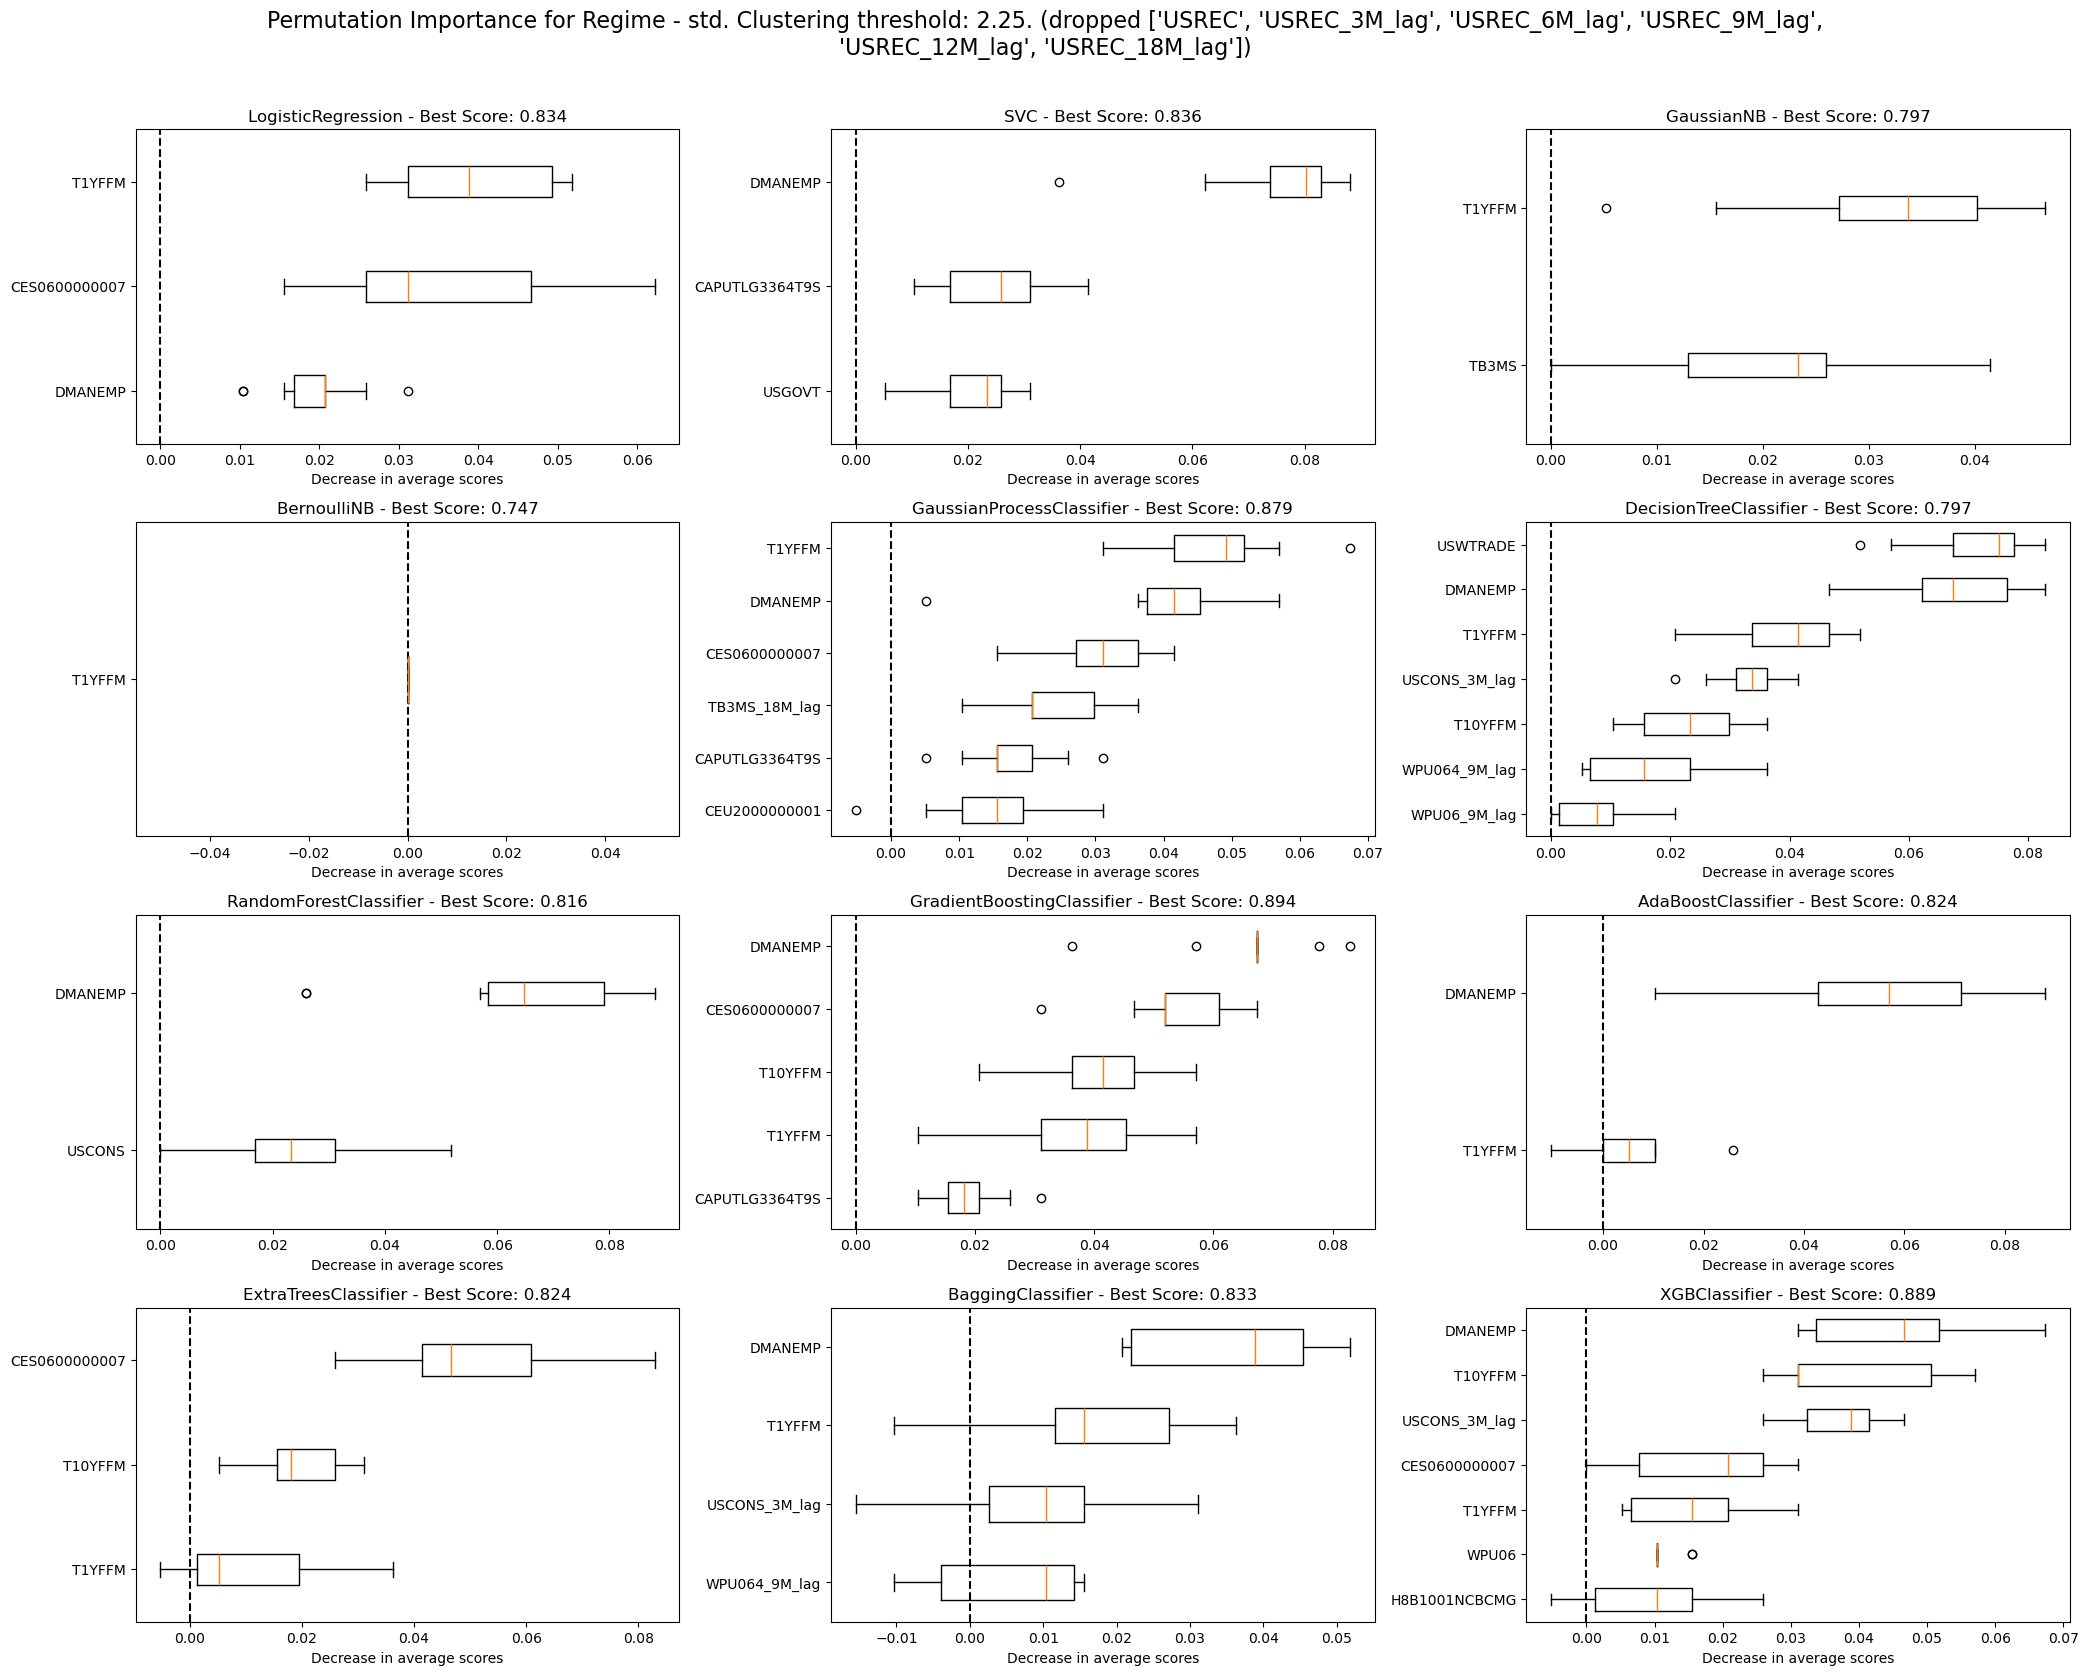

Results exported to permutation_importance_Regime_std.csv
Execution time of optimize_and_evaluate function: 69.69 seconds
Optimization and evaluation complete.


In [168]:
results_df = optimize_and_evaluate(baseline_models, threshold=2.25, target_types=['bear'], split_types=['std'], visualize=True)

print("Optimization and evaluation complete.")


In [169]:
results_df

,model,best_score,best_features
0,LogisticRegression,0.834309,"[T1YFFM, DMANEMP, CES0600000007]"
2,SVC,0.836352,"[DMANEMP, USGOVT, CAPUTLG3364T9S]"
3,GaussianNB,0.796636,"[T1YFFM, TB3MS]"
4,BernoulliNB,0.747087,"[T1YFFM, USCONS, CEU4200000001, CPIAUCNS_18M_l..."
5,GaussianProcessClassifier,0.879136,"[T1YFFM, CEU2000000001, DMANEMP, CES0600000007..."
6,DecisionTreeClassifier,0.797263,"[T10YFFM, T1YFFM, DMANEMP, USWTRADE, USCONS_3M..."
7,RandomForestClassifier,0.815969,"[USCONS, DMANEMP]"
8,GradientBoostingClassifier,0.894181,"[T10YFFM, T1YFFM, DMANEMP, CES0600000007, CAPU..."
9,AdaBoostClassifier,0.823893,"[T1YFFM, DMANEMP, TB3MS_3M_lag, CUUR0000SAF111..."
10,ExtraTreesClassifier,0.823815,"[T10YFFM, T1YFFM, CES0600000007, TB3MS_18M_lag]"


In [174]:
def load_and_parse_results(target='bear', split='std'):
    filename = f'feature_selection/permutation_importance_{target}_{split}.csv'
    results_df = pd.read_csv(filename, sep='\t')
    # drop na
    results_df = results_df.dropna()
    # Parse the 'best_features' column from string representation of a list to an actual list
    results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Helper function to train and evaluate a model on the test set. 
    Returns a dictionary of evaluation metrics.
    """
    model = clone(model)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "recall": recall_score(y_test, Y_pred, average='macro'),
        "roc_auc": roc_auc_score(y_test, Y_pred_proba) if hasattr(model, "predict_proba") else None,
        "accuracy": accuracy_score(y_test, Y_pred),
        "precision": precision_score(y_test, Y_pred, average='macro'),
        "f1": f1_score(y_test, Y_pred, average='macro'),
    }

    results = {metric_name: round(metric_func, 4) for metric_name, metric_func in metrics.items()}
    return results

def get_evaluation(models, X_train, X_test, y_train, y_test, results_df):
    """
    Evaluate the models using the best features found from the feature selection process.
    Returns a DataFrame with the evaluation results.
    """
    evaluation_results = []

    for model in models:
        model_name = model.__class__.__name__
        # Ensure best_features is a flat list of feature names
        best_features_series = results_df.loc[results_df['model'] == model_name, 'best_features']
        if not best_features_series.empty:
            best_features = best_features_series.iloc[0]  # Access the first item if Series is not empty

            # Subset the datasets with the best features
            X_train_best = X_train[best_features].copy()
            X_test_best = X_test[best_features].copy()

            # Check if model needs scaling
            if model_name in model_needs_scaling:
                X_train_best, X_test_best = scale_data(X_train_best, X_test_best)

            # Evaluate the model using the best features
            metrics = train_and_evaluate(model, X_train_best, y_train, X_test_best, y_test)
            evaluation_results.append([model_name] + list(metrics.values()))
        else:
            print(f"No best features found for {model_name}, skipping.")

    # Convert the evaluation results into a DataFrame
    if evaluation_results:
        # Directly use the metric names from the dictionary used in `train_and_evaluate`
        metric_names = ['model'] + list(metrics.keys())  # Use metrics from the last iteration
        evaluation_df = pd.DataFrame(evaluation_results, columns=metric_names)
    else:
        evaluation_df = pd.DataFrame(columns=['model'] + list(metrics.keys()))

    # set the model name as the index
    evaluation_df = evaluation_df.set_index('model')
    evaluation_df.index.name = None

    # sort by recall
    evaluation_df = evaluation_df.sort_values(by='recall', ascending=False)
    return evaluation_df

X_train, y_train, X_test, y_test = load_data(target='bear', split='std')
results_df = load_and_parse_results(target='bear', split='std')
eval_df = get_evaluation(baseline_models, X_train, X_test, y_train, y_test, results_df)
print(eval_df)

# export to csv
eval_df.to_csv("feature_selection/feature_selection_evaluation.csv")

Loaded X_train_Regime_std.csv, y_train_Regime_std.csv, X_test_Regime_std.csv, and y_test_Regime_std.csv.
Dropped USREC column
No best features found for KNeighborsClassifier, skipping.
                            recall  roc_auc  accuracy  precision      f1
GradientBoostingClassifier  0.8361   0.9560    0.9430     0.8798  0.8561
XGBClassifier               0.8331   0.9693    0.9378     0.8606  0.8461
GaussianProcessClassifier   0.7955   0.9435    0.9378     0.8862  0.8327
DecisionTreeClassifier      0.7749   0.7749    0.9016     0.7650  0.7698
BaggingClassifier           0.7532   0.8500    0.8964     0.7532  0.7532
RandomForestClassifier      0.7373   0.8670    0.9016     0.7682  0.7514
SVC                         0.7274   0.9379    0.9171     0.8330  0.7665
LogisticRegression          0.7086   0.9425    0.9171     0.8485  0.7549
ExtraTreesClassifier        0.6692   0.9091    0.8808     0.7100  0.6862
AdaBoostClassifier          0.6621   0.8724    0.9016     0.7919  0.7015
GaussianNB  

In [175]:
from sklearn.model_selection import StratifiedKFold


def perform_cross_validation(target, split, datatype, results_df=results_df, models_list=baseline_models):
    print(f"Performing 10-fold stratified cross-validation on {datatype} data for {target} - {split}.")
    cv_results = []
    precision_scorer = make_scorer(precision_score, zero_division=0)
    f1_scorer = make_scorer(f1_score, zero_division=0)

    scoring_metrics = {
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        # Use the custom scorers for metrics that need zero_division handling
        'precision': precision_scorer,
        'f1': f1_scorer
    }

    X_train, y_train, X_test, y_test = load_data(target=target, split=split)
    if datatype=='train':
        X = X_train
        y = y_train
    
    if datatype=='test':
        X = X_test
        y = y_test

    stratified_cv = StratifiedKFold(
        n_splits=10, shuffle=True, random_state=SEED
    )

    for model in models_list:
        # Find the model in the results DataFrame
        model_name = model.__class__.__name__
        model_row = results_df[results_df['model'] == model_name]
        
        if not model_row.empty:
            important_features = model_row['best_features'].iloc[0]
            X_important = X[important_features]
            
            # check if model needs scoring
            if model_name in model_needs_scaling:
                X_important, _ = scale_data(X_important)

            # Prepare a dictionary to hold all scores for this model
            model_scores = {'model': model_name}

            for metric, scorer in scoring_metrics.items():
                # Perform cross-validation
                cv_scores = cross_val_score(model, X_important, y, cv=stratified_cv, scoring=scorer)
                
                # Update the dictionary with the mean and std of cv scores
                model_scores[f'mean_{metric}_score'] = round(cv_scores.mean(), 4)
                model_scores[f'std_{metric}'] = round(cv_scores.std(), 4)

            # Append the dictionary to cv_results after processing all metrics
            cv_results.append(model_scores)
        else:
            print(f"Model {model_name} not found in DataFrame. Skipping.")

    # Convert results to DataFrame
    df = pd.DataFrame(cv_results)
    df.set_index('model', inplace=True)
    df.index.name = None

    # Sort the DataFrame by one of the scores if desired
    df = df.sort_values(by='mean_roc_auc_score', ascending=False)

    # Save the DataFrame to CSV
    # df.to_csv(f"feature_selection/10_fold_cross_validation_results_{target}_{split}_{datatype}_no_tuning.csv")

    return df

In [179]:
results_df = load_and_parse_results(target='bear', split='std')

cv_results = perform_cross_validation(target='bear', split='std', datatype='test', results_df=results_df)

Performing 10-fold stratified cross-validation on test data for Regime - std.
Loaded X_train_Regime_std.csv, y_train_Regime_std.csv, X_test_Regime_std.csv, and y_test_Regime_std.csv.
Dropped USREC column
Model KNeighborsClassifier not found in DataFrame. Skipping.


In [180]:
cv_results

,mean_recall_score,std_recall,mean_roc_auc_score,std_roc_auc,mean_accuracy_score,std_accuracy,mean_precision_score,std_precision,mean_f1_score,std_f1
LogisticRegression,0.3833,0.2115,0.9324,0.0457,0.9021,0.0416,0.6500,0.3905,0.4638,0.2476
XGBClassifier,0.4833,0.2409,0.9255,0.0839,0.9074,0.0544,0.7000,0.3399,0.5500,0.2478
BaggingClassifier,0.5333,0.2333,0.8887,0.1201,0.9071,0.0586,0.6733,0.3518,0.5638,0.2420
SVC,0.3167,0.3114,0.8873,0.1149,0.8974,0.0592,0.4833,0.4500,0.3733,0.3479
GaussianProcessClassifier,0.3500,0.1893,0.8853,0.0898,0.9074,0.0430,0.6833,0.4113,0.4500,0.2478
GradientBoostingClassifier,0.5167,0.2409,0.8696,0.1309,0.9021,0.0573,0.6333,0.3317,0.5538,0.2548
RandomForestClassifier,0.4500,0.3253,0.8676,0.1996,0.9024,0.0690,0.5833,0.4425,0.4816,0.3432
ExtraTreesClassifier,0.4167,0.3819,0.8657,0.1315,0.9076,0.0536,0.4833,0.4246,0.4300,0.3707
BernoulliNB,0.1667,0.2108,0.8191,0.1305,0.8811,0.0464,0.3500,0.4500,0.2233,0.2829
AdaBoostClassifier,0.4667,0.3232,0.8054,0.1474,0.9021,0.0343,0.5267,0.3210,0.4683,0.2680


In [183]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from select_models import param_grids, baseline_models, SCORING, tune_model

def tune_model(model, results_df, param_grid=None, X_train=X_train, y_train=y_train, scoring=SCORING):
    # Clone the model to avoid side-effects like changing the baseline model list
    model = clone(model)
    model_name = model.__class__.__name__

    param_grid = {
        "n_estimators": [25, 50, 100, 150],
        "loss": ["exponential", "log_loss"],
        "learning_rate": [0.3, 0.25, 0.2, 0.1, .05],
        "max_depth": [2, 3, 4],
        "warm_start": [True, False],
        "subsample": [0.5, 0.75, 1.0],
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3],
    },
    
    best_features_series = results_df.loc[results_df['model'] == model_name, 'best_features']
    if not best_features_series.empty:
        best_features = best_features_series.iloc[0]  # Access the first item if Series is not empty

        # Subset the datasets with the best features
        X_train_best = X_train[best_features].copy()
        X_test_best = X_test[best_features].copy()

        # Check if model needs scaling
        if model_name in model_needs_scaling:
            X_train_best, X_test_best = scale_data(X_train_best, X_test_best)

    print(f"Tuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train_best, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"model: {model_name}")
    print(f"best params: {best_params}")
    print(f"best {scoring} score: {round(best_score, 4)}")

    best_model = model.set_params(**best_params)
    return best_model, best_params

model=GradientBoostingClassifier(random_state=SEED)

results_df = load_and_parse_results(target='bear', split='std')

best_model, best_params = tune_model(model, results_df=results_df)


Tuning hyperparameters for GradientBoostingClassifier...
model: GradientBoostingClassifier
best params: {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.5, 'warm_start': True}
best roc_auc score: 0.9496


In [184]:
perform_cross_validation(target='bear', split='std', datatype='test', results_df=results_df, models_list=[best_model])

Performing 10-fold stratified cross-validation on test data for Regime - std.
Loaded X_train_Regime_std.csv, y_train_Regime_std.csv, X_test_Regime_std.csv, and y_test_Regime_std.csv.
Dropped USREC column


,mean_recall_score,std_recall,mean_roc_auc_score,std_roc_auc,mean_accuracy_score,std_accuracy,mean_precision_score,std_precision,mean_f1_score,std_f1
GradientBoostingClassifier,0.6667,0.2236,0.8985,0.1115,0.9176,0.068,0.7433,0.2638,0.6694,0.1902
